**ANALYSE DE LA BASE DE DONNEES OPEN DAMIR**

Cette base de données présente les remboursements de soins effectués par l'ensemble des régimes d'assurance maladie.  \
**Source données** : https://open-data-assurance-maladie.ameli.fr/depenses/download.php?Dir_Rep=Open_DAMIR&Annee=2024  \
**Fichier utilisé** : 'A202412.csv.gz'  \
**Source Fichier Descriptif des variables** : https://www.assurance-maladie.ameli.fr/content/descriptif-des-variables-de-la-serie-open-damir-base-complete

Ce projet constitue une initiative personnelle destinée à valoriser mes compétences en analyse de données tout en perfectionnant mon utilisation des outils et méthodologies associés. Il vise à explorer et analyser en profondeur les facteurs influençant les remboursements effectués par l'assurance maladie, en s'appuyant sur les données disponibles dans la base Open Damir. Cette base exhaustive, actualisée régulièrement et comprenant des données mensuelles depuis janvier 2009, offre une vision détaillée des dépenses des différents régimes d'assurance maladie en France.

En exploitant des variables fondamentales telles que les montants dépensés, les sommes remboursées, la nature des prestations et l'âge des bénéficiaires, cette étude ambitionne de dévoiler les interrelations complexes entre ces paramètres.

En mobilisant des outils statistiques avancés, des visualisations percutantes et une méthodologie rigoureuse, ce projet se fixe pour objectif de générer des résultats précis et exploitables. Parallèlement, il me permet de mettre en lumière mes compétences analytiques et d'approfondir ma compréhension des données de la CPAM ainsi que des dynamiques internes liées aux remboursements des prestations.

In [59]:
# Importation des librairies
import zipfile
import gzip
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import kstest

In [25]:
gzip_path = 'H:\\DATA\\Datafiles\\Projets\\CPAM_Data\\A202412.csv.gz'

# Importation des données et du fichier descriptif des variables
open_damir_data = pd.read_csv(gzip_path, sep=';', compression='gzip')

fichier_excel = "2024_descriptif-variables_open-damir-base-complete.xlsx"
nom_feuille = "MOD OPEN DAMIR"

varmod = pd.read_excel(fichier_excel, sheet_name=nom_feuille)

In [26]:
open_damir_data.head()

,FLX_ANN_MOI,ORG_CLE_REG,AGE_BEN_SNDS,BEN_RES_REG,BEN_CMU_TOP,BEN_QLT_COD,BEN_SEX_COD,DDP_SPE_COD,ETE_CAT_SNDS,ETE_REG_COD,...,PSE_SPE_SNDS,PSE_STJ_SNDS,PRE_INS_REG,PSP_ACT_SNDS,PSP_ACT_CAT,PSP_SPE_SNDS,PSP_STJ_SNDS,TOP_PS5_TRG,ETB_DCS_MCO,Unnamed: 56
0,202412,84,80,84,0,1,1,121,9999,99,...,0,9,99,0,0,0,9,1,Z,NaN
1,202412,99,40,44,0,1,1,121,9999,99,...,6,1,5,0,1,6,1,1,Z,NaN
2,202412,24,60,24,0,1,1,121,9999,99,...,0,1,99,0,0,11,2,1,Z,NaN
3,202412,52,0,52,0,3,2,121,9999,99,...,0,1,99,0,0,1,2,1,Z,NaN
4,202412,11,60,11,0,1,1,121,9999,99,...,0,1,99,0,0,1,2,1,Z,NaN


In [27]:
# Selection des descriptions de la variable 'PRS_NAT' (nature de prestation)
# Selectionne les deux premières colonnes
varmod_prs_nat = varmod.iloc[:, :2]
varmod_prs_nat.columns = ['variable', 'description']
varmod_prs_nat = varmod_prs_nat.iloc[556:2125, :].reset_index(drop=True)
varmod_prs_nat.head()

,variable,description
0,0,SANS OBJET
1,1039,TELECONSULTATION PEDIATRE 2-6 ANS
2,1040,TELECONSULTATION PEDIATRE 0-2 ANS
3,1041,CONSULT. PSYCHIATRE NEUROLOGUE
4,1042,CONSULTATION PEDIATRE 0-2 ANS


In [28]:
varmod_prs_nat.shape[0]

1569

Le fichier descriptif des variables Open Damir recense 1569 prestations, soit l'ensemble des services fournis par l'assurance maladie. Étant donné le nombre élevé de prestations, notre analyse se focalisera sur les 100 premières, classées selon les montants versés, les montants dépensés, et le nombre d'actes réalisés.

In [29]:
# Création d'un dictionnaire de la variable 'PRS_NAT'
prsnat_dict = dict(zip(varmod_prs_nat['variable'], varmod_prs_nat['description']))
print(prsnat_dict)

{0: 'SANS OBJET', 1039: 'TELECONSULTATION PEDIATRE 2-6 ANS', 1040: 'TELECONSULTATION PEDIATRE 0-2 ANS', 1041: 'CONSULT. PSYCHIATRE NEUROLOGUE', 1042: 'CONSULTATION PEDIATRE 0-2 ANS', 1043: 'CONSULTATION PEDIATRE 2-6 ANS', 1044: 'CONSULTATION PEDIATRE 6 ANS ET +', 1045: 'EXAM PARENTAL GROSSESSE CO-PARENT', 1046: 'TELECONSULTATION SPECIALISTE', 1047: 'CONSULTATION PSYCHIATRE RAPIDE SUITE ORIENTATION SAS OU MTT', 1048: 'CONSULTATION INIT MT ALD', 1049: 'SUPPL. PEDIATRIQUE URGENCE 2', 1050: 'FORFAIT CONSULTATION URGENCE 0', 1051: 'SUPPL. PEDIATRIQUE URGENCE 1', 1052: 'REMU BIOSIMILAIRE', 1053: 'FORFAIT VSM', 1054: 'BILAN MRTC', 1055: 'SUIVI MRTC', 1056: 'TELECONSULTATION GENERALISTE IVG', 1057: 'TELECONSULTATION SPECIALISTE IVG', 1058: 'EXAMEN OBLIGATOIRE ENFANT COJ', 1059: 'EXAMEN OBLIGATOIRE ENFANT COK', 1060: 'MAJORATION GYNECO MEDICALE', 1061: 'MAJORATION PSY ENFANT', 1062: 'CDE CONGE PARENTAL', 1063: 'CDE CONGE MALADIE', 1064: 'CDE GARANTIE REVENU 1ERE ANNEE', 1065: 'FORFAIT EFFECTEUR

In [30]:
# Création d'un dataframe avec les variables:
# AGE_BEN_SNDS : Tranche d'Age Bénéficiaire au moment des soins,
# PRS_PAI_MNT : Montant payé par les patients, 
# PRS_REM_MNT : Montant versé/remboursé par l'Assurance Maladie, 
# PRS_NAT : Nature de la prestation

presta_data = open_damir_data[['AGE_BEN_SNDS', 'BEN_SEX_COD', 'PRS_ACT_QTE', 'PRS_PAI_MNT', 'PRS_REM_MNT', 'PRS_REM_BSE', 'PRS_REM_TAU', 'PRS_NAT']].copy()
presta_data.loc[:, 'PRS_NAT_DESC'] = presta_data['PRS_NAT'].map(prsnat_dict)
presta_data['DIFF']= presta_data['PRS_PAI_MNT'] - abs(presta_data['PRS_REM_MNT'])

presta_df = pd.DataFrame(presta_data)
presta_df.head()

,AGE_BEN_SNDS,BEN_SEX_COD,PRS_ACT_QTE,PRS_PAI_MNT,PRS_REM_MNT,PRS_REM_BSE,PRS_REM_TAU,PRS_NAT,PRS_NAT_DESC,DIFF
0,80,1,2,2.70,2.70,2.70,100.0,3116,MAJORATION POUR ACTE UNIQUE,0.00
1,40,1,3,0.00,-6.00,0.00,100.0,1952,PARTICIPATION FORFAITAIRE TIERS PAYANT,-6.00
2,60,1,3,120.12,120.12,120.12,100.0,3132,ACTES DES ORTHOPHONISTES,0.00
3,0,2,2,60.32,36.20,60.32,60.0,3132,ACTES DES ORTHOPHONISTES,24.12
4,60,1,2,0.00,-2.00,0.00,100.0,1976,FRANCHISE TIERS PAYANT ACTE D'AUXILIAIRE MEDICAUX,-2.00


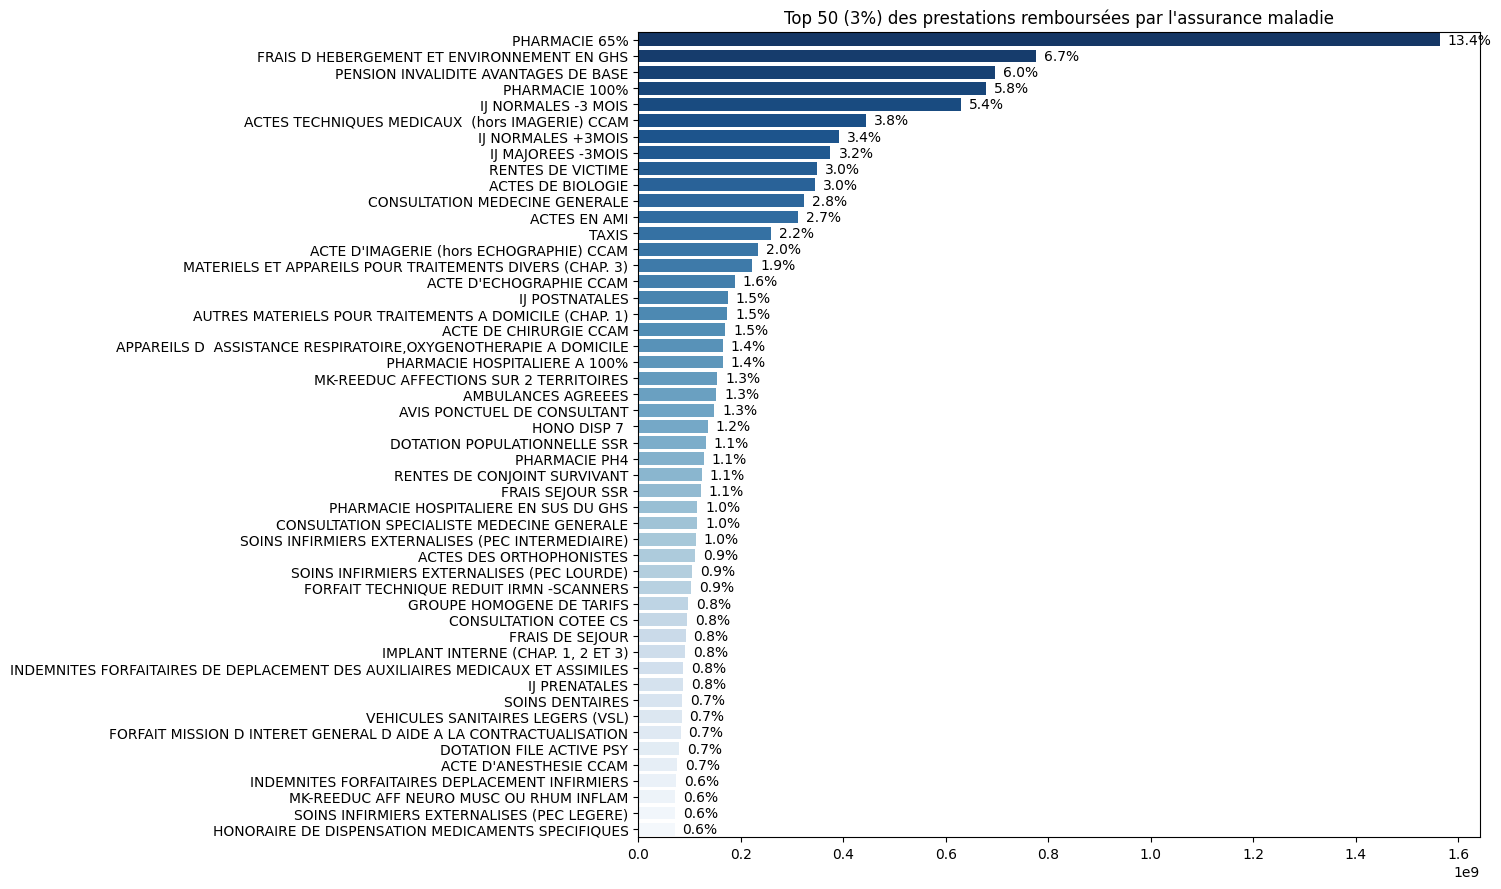

In [31]:
grouped_data = presta_df.groupby('PRS_NAT_DESC')['PRS_REM_MNT'].sum().reset_index()
top_prs_rem = grouped_data.sort_values(by='PRS_REM_MNT', ascending=False).head(50)
top_prs_rem['Percentage'] = (top_prs_rem['PRS_REM_MNT'] / top_prs_rem['PRS_REM_MNT'].sum()) * 100

# Diagramme en barres horizontal
plt.figure(figsize=(15, 9))
sns.barplot(
    x='PRS_REM_MNT',
    y='PRS_NAT_DESC',
    data=top_prs_rem,
    palette='Blues_r',  #
    hue='PRS_NAT_DESC',  
    dodge=False  
)

# Ajout des pourcentages
for index, row in enumerate(top_prs_rem.itertuples()):
    percentage = f"{row.Percentage:.1f}%"
    plt.text(row.PRS_REM_MNT + 0.01 * top_prs_rem['PRS_REM_MNT'].max(),
             index,
             percentage,
             va='center')

plt.xlabel('')
plt.ylabel('')
plt.title("Top 50 (3%) des prestations remboursées par l'assurance maladie")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

Les données révèlent que les actes en pharmacie (remboursés à 100 % et à 65 %) constituent environ 20 % des 50 prestations les plus remboursées par la CPAM. Juste après, on trouve les indemnités journalières, qui représentent 12 % de ce top 50. D'autres catégories notables incluent les actes d'hébergement et d'environnement dans les GHS, les pensions d'invalidité (avantage de base), les actes techniques médicaux, ainsi que les consultations de médecine générale, entre autres. 

Cette répartition met en lumière la diversité des types de prestations financées par l'assurance maladie et l'importance relative de chaque catégorie dans les dépenses de remboursement. Cela incite aussi à approfondir l'analyse pour mieux comprendre les besoins des bénéficiaires et optimiser les allocations budgétaires.

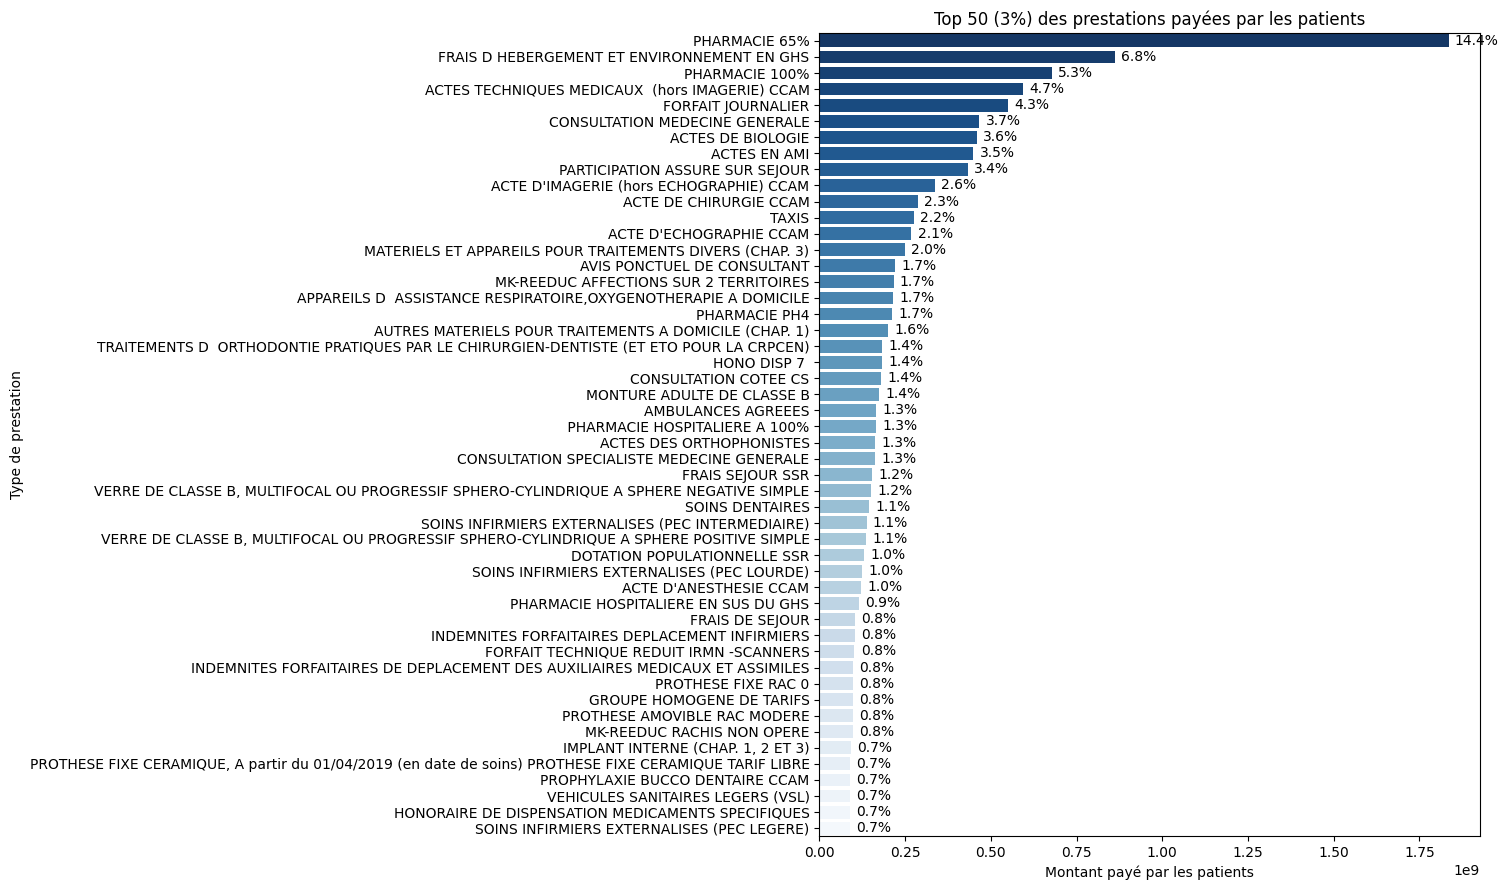

In [32]:
grouped_data_pai = presta_df.groupby('PRS_NAT_DESC')['PRS_PAI_MNT'].sum().reset_index()
top_prs_pai = grouped_data_pai.sort_values(by='PRS_PAI_MNT', ascending=False).head(50)
top_prs_pai['Percentage'] = (top_prs_pai['PRS_PAI_MNT'] / top_prs_pai['PRS_PAI_MNT'].sum()) * 100

# Diagramme en barres horizontal
plt.figure(figsize=(15, 9))
sns.barplot(
    x='PRS_PAI_MNT',
    y='PRS_NAT_DESC',
    data=top_prs_pai,
    palette='Blues_r',  #
    hue='PRS_NAT_DESC',  
    dodge=False  
)

# Ajout des pourcentages
for index, row in enumerate(top_prs_pai.itertuples()):
    percentage = f"{row.Percentage:.1f}%"
    plt.text(row.PRS_PAI_MNT + 0.01 * top_prs_pai['PRS_PAI_MNT'].max(),
             index,
             percentage,
             va='center')

plt.xlabel('Montant payé par les patients')
plt.ylabel('Type de prestation')
plt.title('Top 50 (3%) des prestations payées par les patients')
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

Concernant les prestations payées par les patients, on constate que la majorité d'entre elles sont effectivement remboursées par l'assurance maladie. Toutefois, les forfaits journaliers occupent une part notable dans cette catégorie, représentant environ 4,3 % du top 50 des prestations réglées par les patients, sans être couvertes par l'assurance maladie. 

Cette observation met en lumière une distinction importante entre les prestations remboursées et celles restant à la charge des bénéficiaires, comme les forfaits journaliers. Ces derniers peuvent représenter un défi financier pour certains patients, et leur rôle dans le système de santé mérite une attention particulière, notamment dans le cadre d'une analyse des dépenses globales des ménages en santé. 

Malheureusement comparer un si grand volume de prestations, entre celles sollicitées par les patients et celles remboursées par l'assurance maladie, peut rapidement devenir une tâche complexe. Raison pour laquelle nous allons nous concentrer sur des catégories clés ou des agrégats, comme les 50 ou 100 prestations les plus fréquentes ou les plus coûteuses, afin de dégager des tendances générales.

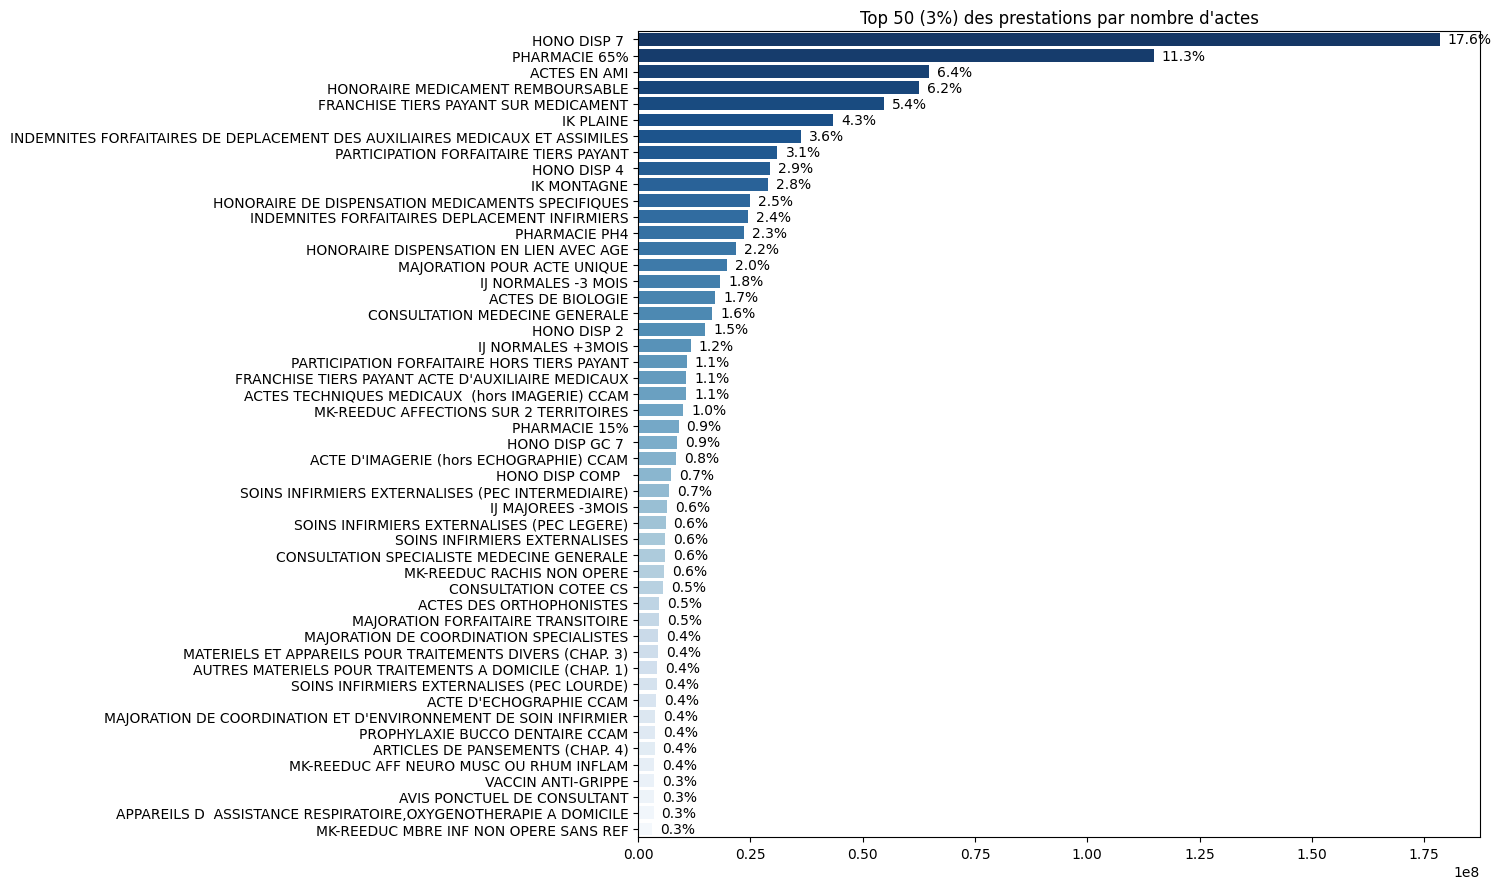

In [33]:
grouped_data_act = presta_df.groupby('PRS_NAT_DESC')['PRS_ACT_QTE'].sum().reset_index()
top_prs_act = grouped_data_act.sort_values(by='PRS_ACT_QTE', ascending=False).head(50)
top_prs_act['Percentage'] = (top_prs_act['PRS_ACT_QTE'] / top_prs_act['PRS_ACT_QTE'].sum()) * 100

# Diagramme en barres horizontal
plt.figure(figsize=(15, 9))
sns.barplot(
    x='PRS_ACT_QTE',
    y='PRS_NAT_DESC',
    data=top_prs_act,
    palette='Blues_r',  #
    hue='PRS_NAT_DESC',  
    dodge=False  
)

# Ajout des pourcentages
for index, row in enumerate(top_prs_act.itertuples()):
    percentage = f"{row.Percentage:.1f}%"
    plt.text(row.PRS_ACT_QTE + 0.01 * top_prs_act['PRS_ACT_QTE'].max(),
             index,
             percentage,
             va='center')

plt.xlabel('')
plt.ylabel('')
plt.title("Top 50 (3%) des prestations par nombre d'actes")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

En termes de nombre d'actes, on observe que les honoraires de dispensation, incluant Hono disp 4 et 7 (représentant environ 20 % du top 50 des actes sollicités), ainsi que les actes en pharmacie (remboursés à 65 %), les honoraires liés aux médicaments remboursables, et les franchises tiers payants sur les médicaments figurent parmi les prestations les plus demandées par les patients. 

Les actes réalisés à domicile, tels que les indemnités forfaitaires pour le déplacement des auxiliaires médicaux et assimilés, ainsi que les indemnités kilométriques (IK plaine et montagne), sont également très sollicités, avec d'autres prestations diverses.

Il serait intéressant d'analyser lesquelles de ces prestations sont effectivement remboursées par l'assurance maladie afin d'examiner l'éventuelle corrélation entre le nombre d'actes réalisés et leur niveau de remboursement. Une telle étude pourrait fournir des insights utiles pour mieux comprendre la dynamique du système de santé et les préférences des patients.

In [46]:
# Création d'un dataframe regroupant les prestations par total de montant remboursé, dépensé et nombre d'actes

agg_data_presta_rem = presta_df.groupby('PRS_NAT_DESC')['PRS_REM_MNT'].sum().reset_index()
top_agg_data_presta_rem = agg_data_presta_rem.sort_values(by='PRS_REM_MNT', ascending=False).head(100)

agg_data_presta_pai = presta_df.groupby('PRS_NAT_DESC')['PRS_PAI_MNT'].sum().reset_index()
top_agg_data_presta_pai = agg_data_presta_pai.sort_values(by='PRS_PAI_MNT', ascending=False).head(100)

agg_data_presta_qte = presta_df.groupby('PRS_NAT_DESC')['PRS_ACT_QTE'].sum().reset_index()
top_agg_data_presta_qte = agg_data_presta_qte.sort_values(by='PRS_ACT_QTE', ascending=False).head(100)

agg_data_presta_rem_taux = presta_df.groupby('PRS_NAT_DESC')['PRS_REM_TAU'].mean().reset_index()
top_agg_data_presta_rem_taux = agg_data_presta_rem_taux.sort_values(by='PRS_REM_TAU', ascending=False)

# Fusion des données top 100 en un seul dataframe
top_agg_data_merged = pd.merge(top_agg_data_presta_rem, top_agg_data_presta_pai, on='PRS_NAT_DESC', suffixes=('_REM', '_PAI'))
top100_agg_data_presta_merged = pd.merge(top_agg_data_merged, top_agg_data_presta_qte, on='PRS_NAT_DESC')
top100_agg_data_presta_merged.sort_values('PRS_NAT_DESC', inplace=True)

#fusion des données complètes en un seul dataframe
agg_data_merged = pd.merge(agg_data_presta_rem, agg_data_presta_pai, on='PRS_NAT_DESC', suffixes=('_REM', '_PAI'))
agg_data_presta_merged = pd.merge(agg_data_merged, agg_data_presta_qte, on='PRS_NAT_DESC')
agg_data_presta_merged.sort_values('PRS_NAT_DESC', inplace=True)

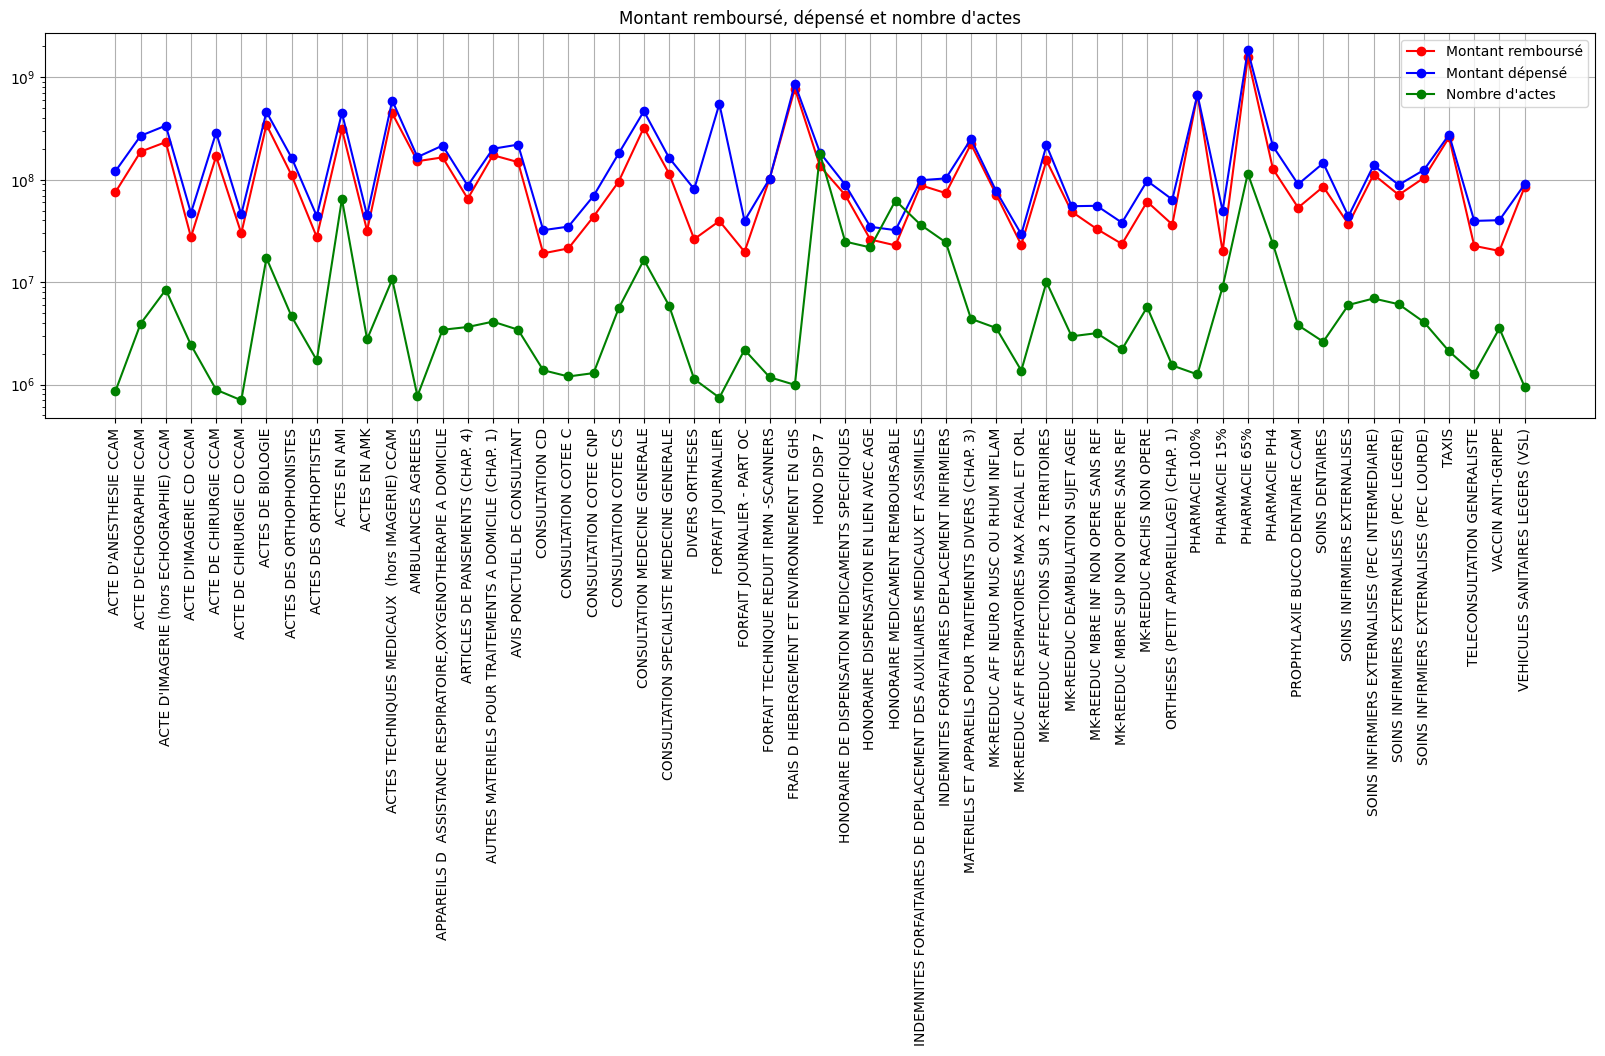

In [35]:
plt.figure(figsize=(20, 5))
plt.plot(top100_agg_data_presta_merged['PRS_NAT_DESC'], top100_agg_data_presta_merged['PRS_REM_MNT'], color='red', marker='o', label='Montant remboursé')
plt.plot(top100_agg_data_presta_merged['PRS_NAT_DESC'], top100_agg_data_presta_merged['PRS_PAI_MNT'], color='blue', marker='o', label='Montant dépensé')
plt.plot(top100_agg_data_presta_merged['PRS_NAT_DESC'], top100_agg_data_presta_merged['PRS_ACT_QTE'], color='green', marker='o', label="Nombre d'actes")
plt.yscale('log')
plt.xlabel('')
plt.ylabel(None)
plt.title("Montant remboursé, dépensé et nombre d'actes")
plt.legend()
plt.grid(True)
plt.xticks(ticks=range(len(top100_agg_data_presta_merged['PRS_NAT_DESC'])), 
           labels=top100_agg_data_presta_merged['PRS_NAT_DESC'], rotation=90)
plt.show()

En examinant les 100 premières prestations selon les montants remboursés par l'assurance maladie, les dépenses des patients et le nombre d'actes sollicités, une tendance générale se dessine : une corrélation positive est souvent observable. En effet, l'augmentation du nombre d'actes est généralement associée à une hausse des dépenses des patients, ce qui entraîne à son tour une augmentation des remboursements effectués par l'assurance maladie.
Toutefois, des exceptions notables émergent pour certains types de prestations. Par exemple, les actes de chirurgie CCAM, les forfaits d'hébergement et d'environnement en GHS, ainsi que les actes en pharmacie remboursés à 100 % présentent des montants élevés malgré un nombre relativement faible d'actes. Ces prestations illustrent des cas où la complexité, la rareté ou la spécificité de l'acte conduit à un coût disproportionné par rapport à la quantité réalisée.

Une analyse plus approfondie de ces anomalies pourrait fournir des pistes pour optimiser les allocations de ressources ou mieux comprendre les besoins spécifiques des patients et les enjeux économiques liés à ces prestations.

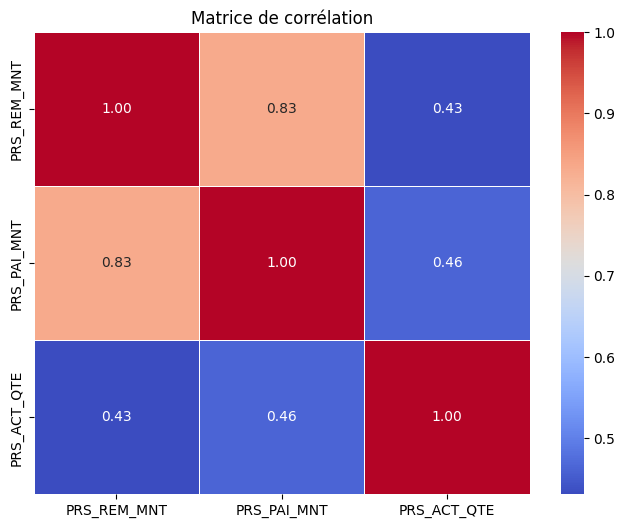

In [36]:
# Sélectionner uniquement les colonnes numériques pour la matrice de corrélation
numeric_columns = agg_data_presta_merged.select_dtypes(include=[np.number])

# Calculer la matrice de corrélation
correlation_matrix = numeric_columns.corr()

# Heatmap avec Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

La matrice de corrélation apporte effectivement un éclairage supplémentaire sur les observations faites plus haut. Le coefficient de corrélation de 0,83 entre les montants payés par les patients et les montants remboursés par l'assurance maladie souligne une forte relation linéaire entre ces deux variables. Cela confirme que, dans la plupart des cas, lorsque les dépenses des patients augmentent, les remboursements suivent une tendance similaire.
En revanche, le coefficient relativement faible de 0,43 entre le nombre d'actes et les montants, qu'ils soient dépensés par les patients ou remboursés par l'assurance maladie, indique une relation moins directe. Cela peut être attribué à des cas particuliers où un faible nombre d'actes engendre des montants élevés (comme les actes de chirurgie, les forfaits GHS, etc.). Ces prestations coûtent cher indépendamment de la fréquence des actes.
Cette divergence mérite une analyse approfondie pour comprendre les facteurs qui influencent ces écarts. Par exemple, des variables comme le type de prestation, la localisation géographique ou la nature des actes pourraient jouer un rôle.

In [37]:
# Regroupement des données par age des patients
agg_age_data_rem = presta_df.groupby('AGE_BEN_SNDS')['PRS_REM_MNT'].sum().reset_index()
agg_age_data_pai = presta_df.groupby('AGE_BEN_SNDS')['PRS_PAI_MNT'].sum().reset_index()
agg_age_data_qte = presta_df.groupby('AGE_BEN_SNDS')['PRS_ACT_QTE'].sum().reset_index()
agg_age_data_merged_fp = pd.merge(agg_age_data_rem, agg_age_data_pai, on='AGE_BEN_SNDS', suffixes=('_REM', '_PAI'))
agg_age_data_merged = pd.merge(agg_age_data_merged_fp, agg_age_data_qte, on='AGE_BEN_SNDS')

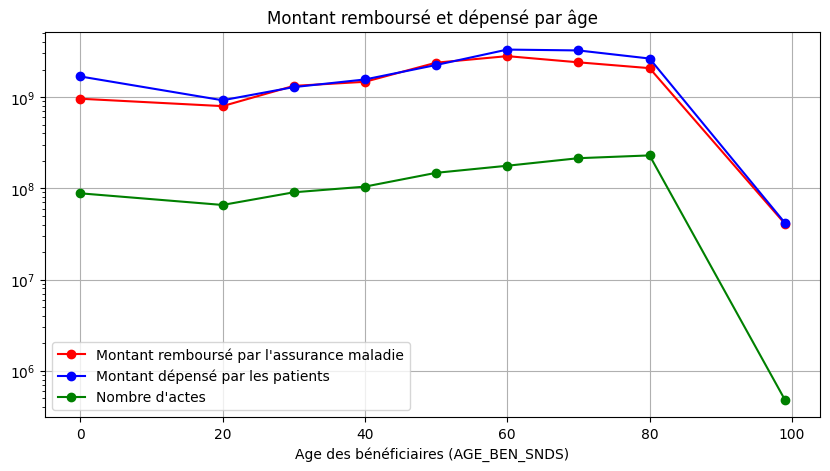

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(agg_age_data_merged['AGE_BEN_SNDS'], agg_age_data_merged['PRS_REM_MNT'], color='red', marker='o', label="Montant remboursé par l'assurance maladie")
plt.plot(agg_age_data_merged['AGE_BEN_SNDS'], agg_age_data_merged['PRS_PAI_MNT'], color='blue', marker='o', label='Montant dépensé par les patients')
plt.plot(agg_age_data_merged['AGE_BEN_SNDS'], agg_age_data_qte['PRS_ACT_QTE'], color='green', marker='o', label='Nombre d\'actes')
plt.yscale('log')
plt.xlabel('Age des bénéficiaires (AGE_BEN_SNDS)')
plt.ylabel(None)
plt.title('Montant remboursé et dépensé par âge')
plt.legend()
plt.grid(True)
plt.show()

La visualisation des données selon les tranches d'âge des bénéficiaires met en évidence des dynamiques intéressantes. Elle révèle que l'utilisation des prestations croît avec l'âge, probablement en raison d'une augmentation des besoins médicaux chez les populations plus âgées. En revanche, les bénéficiaires âgés de 20 à 29 ans constituent la catégorie sollicitant le moins de prestations, ce qui peut s'expliquer par une meilleure santé générale ou un recours moins fréquent aux services médicaux.

D'autre part, les montants remboursés par l'assurance maladie apparaissent légèrement inférieurs ou, dans certains cas, équivalents aux montants dépensés par les patients, et ce, quelle que soit la tranche d'âge. Ce constat met en lumière une disparité qui pourrait être attribuée à des limites dans les politiques de remboursement ou à une prise en charge partielle de certaines prestations.

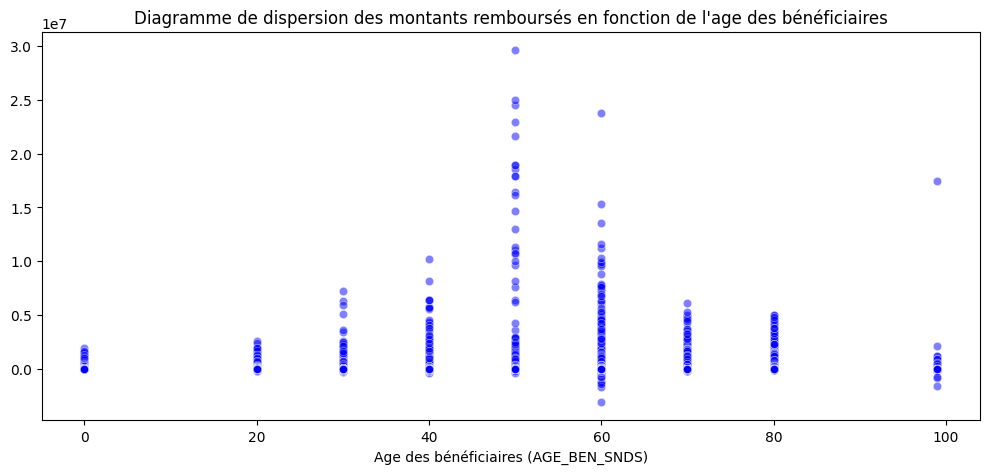

In [100]:
# Tracé du diagramme de dispersion avec Seaborn

plt.figure(figsize=(10, 5))
sns.scatterplot(
    x='AGE_BEN_SNDS', 
    y='PRS_REM_MNT', 
    data=presta_df, 
    alpha=0.5,
    color='blue'
)

# Ajout des labels et du titre
plt.xlabel('Age des bénéficiaires (AGE_BEN_SNDS)')
plt.ylabel('')
plt.title("Diagramme de dispersion des montants remboursés en fonction de l'age des bénéficiaires")

plt.tight_layout()
plt.show()

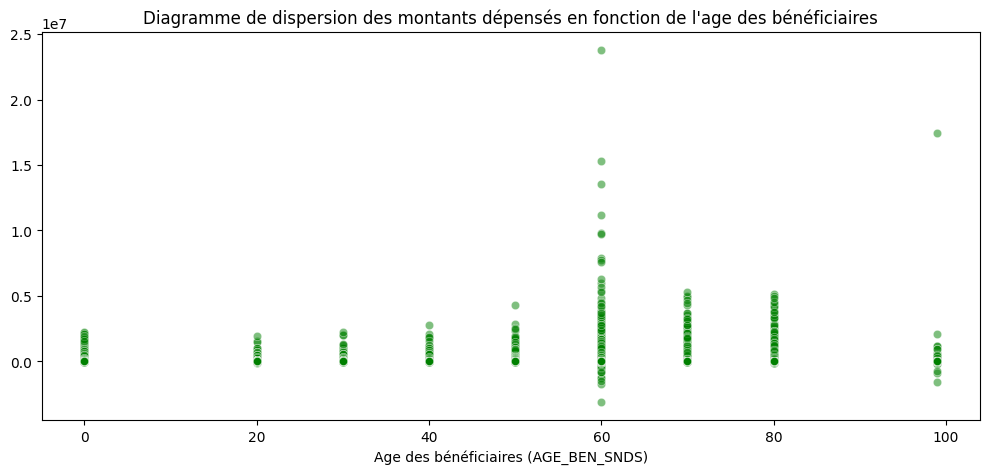

In [102]:
plt.figure(figsize=(10, 5))
sns.scatterplot(
    x='AGE_BEN_SNDS', 
    y='PRS_PAI_MNT', 
    data=presta_df, 
    alpha=0.5,
    color='green'
)

# Ajout des labels et du titre
plt.xlabel('Age des bénéficiaires (AGE_BEN_SNDS)')
plt.ylabel('')
plt.title("Diagramme de dispersion des montants dépensés en fonction de l'age des bénéficiaires")

plt.tight_layout()
plt.show()

In [47]:
top100_agg_data_presta_rem_taux = pd.merge(top100_agg_data_presta_merged, top_agg_data_presta_rem_taux, on='PRS_NAT_DESC')
top100_agg_data_presta_rem_taux.sort_values('PRS_NAT_DESC', inplace=True)

In [48]:
top100_agg_data_presta_rem_taux

,PRS_NAT_DESC,PRS_REM_MNT,PRS_PAI_MNT,PRS_ACT_QTE,PRS_REM_TAU
0,ACTE D'ANESTHESIE CCAM,7.571759e+07,1.212304e+08,863045,97.663365
1,ACTE D'ECHOGRAPHIE CCAM,1.878638e+08,2.683606e+08,3931577,75.307106
2,ACTE D'IMAGERIE (hors ECHOGRAPHIE) CCAM,2.329201e+08,3.373490e+08,8433052,75.258584
3,ACTE D'IMAGERIE CD CCAM,2.748412e+07,4.731327e+07,2436743,62.668151
4,ACTE DE CHIRURGIE CCAM,1.693045e+08,2.879527e+08,890407,84.714653
5,ACTE DE CHIRURGIE CD CCAM,2.994334e+07,4.582430e+07,702165,72.329782
6,ACTES DE BIOLOGIE,3.439793e+08,4.592378e+08,17179188,75.511300
7,ACTES DES ORTHOPHONISTES,1.104583e+08,1.638075e+08,4618187,72.876039
8,ACTES DES ORTHOPTISTES,2.750942e+07,4.406546e+07,1726587,65.597433
9,ACTES EN AMI,3.114161e+08,4.492730e+08,64788558,77.124827


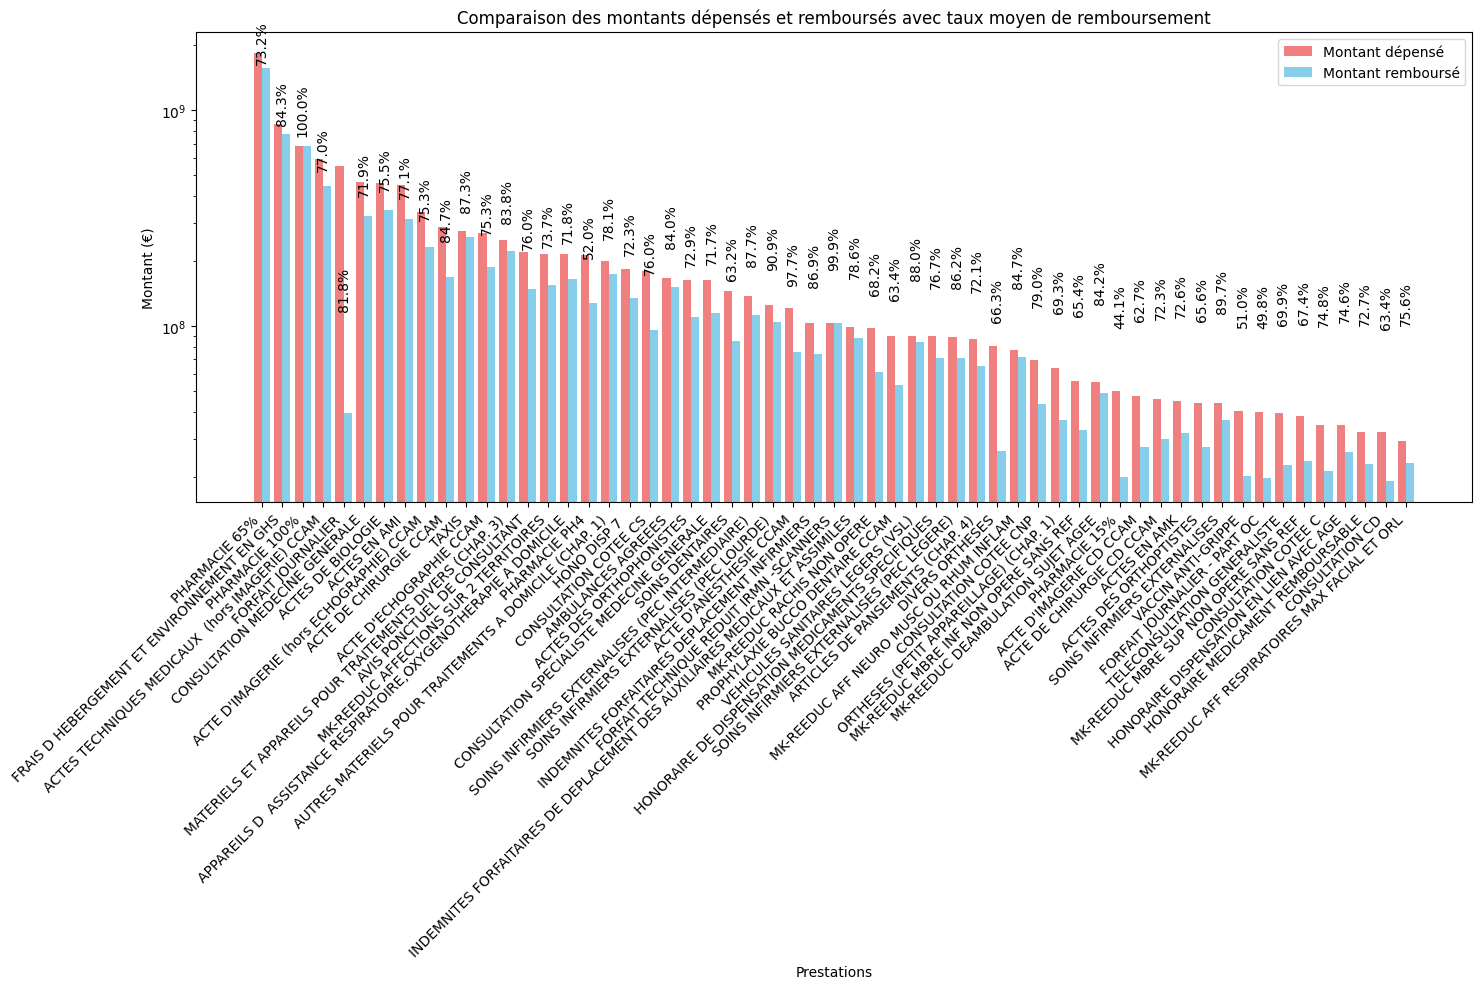

In [51]:
# Trier les données par montant dépensé de façon croissante
top100_agg_data_presta_rem_taux_sorted = top100_agg_data_presta_rem_taux.sort_values(by='PRS_PAI_MNT', ascending=False)

# Création des positions pour les barres
x = np.arange(len(top100_agg_data_presta_rem_taux_sorted['PRS_NAT_DESC']))
width = 0.4

# Tracer les barres
plt.figure(figsize=(15, 10))
plt.bar(x - width/2, top100_agg_data_presta_rem_taux_sorted['PRS_PAI_MNT'], width=width, label='Montant dépensé', color='lightcoral')
plt.bar(x + width/2, top100_agg_data_presta_rem_taux_sorted['PRS_REM_MNT'], width=width, label='Montant remboursé', color='skyblue')

# Ajouter les labels des prestations
plt.xticks(x, top100_agg_data_presta_rem_taux_sorted['PRS_NAT_DESC'], rotation=45, ha='right')

# Annoter le taux de remboursement sur les barres
for idx in range(len(x)):
    taux_remboursement = f"{top100_agg_data_presta_rem_taux_sorted['PRS_REM_TAU'].iloc[idx]:.1f}%"
    plt.text(x[idx], 
             top100_agg_data_presta_rem_taux_sorted['PRS_REM_MNT'].iloc[idx] + 0.05 * top100_agg_data_presta_rem_taux_sorted['PRS_REM_MNT'].max(), 
             taux_remboursement, 
             ha='center', va='bottom', color='black', rotation=90)

plt.yscale('log')

# Ajustements et affichage
plt.xlabel('Prestations')
plt.ylabel('Montant (€)')
plt.title('Comparaison des montants dépensés et remboursés avec taux moyen de remboursement')
plt.legend()
plt.tight_layout()
plt.show()

Ce graphique compare les montants dépensés et remboursés pour les prestations les plus sollicitées par les bénéficiaires, tout en intégrant les taux de remboursement moyens. Il constitue un outil précieux pour évaluer la cohérence entre les politiques de remboursement et les montants effectivement remboursés.

Les taux affichés représentent des moyennes, calculées à partir de plusieurs cas pour une même prestation. Cette approche peut être influencée par des valeurs extrêmes ou des situations spécifiques, pouvant entraîner des écarts significatifs. Par exemple, pour les forfaits journaliers, on remarque que le taux moyen affiché et le montant remboursé semblent incohérents. Cette divergence peut être liée à des valeurs atypiques dans la base de données ou à des cas particuliers qui affectent le taux global.

Ces observations mettent en lumière l'importance d'analyser en détail les écarts détectés. Cela pourrait inclure une exploration des valeurs extrêmes, une étude des règles spécifiques de remboursement ou une vérification des anomalies potentielles. Une telle analyse pourrait offrir des perspectives intéressantes pour comprendre les limites des politiques actuelles ou identifier des axes d'amélioration.

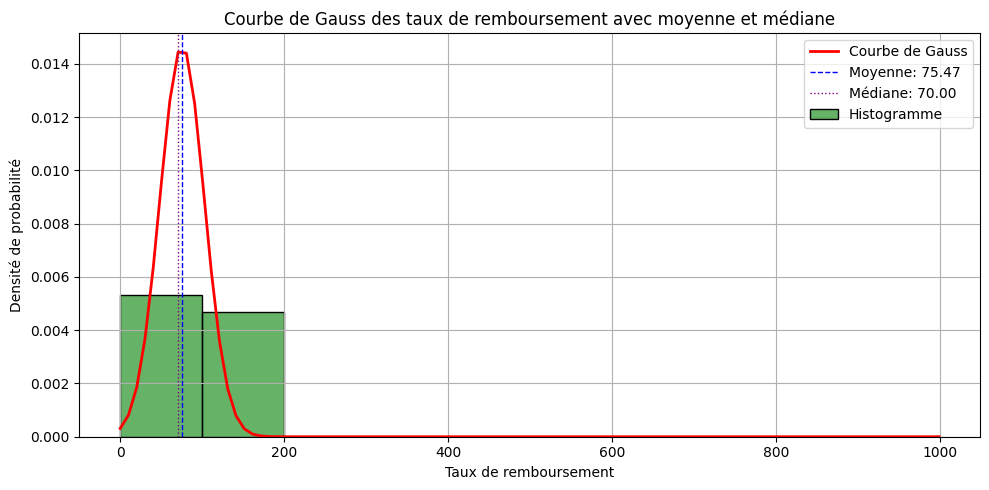

In [55]:
# Calcul des statistiques
mu, sigma = presta_df['PRS_REM_TAU'].mean(), presta_df['PRS_REM_TAU'].std()
median = presta_df['PRS_REM_TAU'].median()

# Tracé de l'histogramme avec Seaborn
plt.figure(figsize=(10, 5))
sns.histplot(
    presta_df['PRS_REM_TAU'], bins=10, stat="density", kde=False, color='g', alpha=0.6, label='Histogramme'
)

# Calcul de la courbe de Gauss
bins = np.linspace(presta_df['PRS_REM_TAU'].min(), presta_df['PRS_REM_TAU'].max(), 100)
gauss_curve = norm.pdf(bins, mu, sigma)

# Tracé de la courbe de Gauss
plt.plot(bins, gauss_curve, linewidth=2, color='r', label='Courbe de Gauss')

# Ajout des lignes pour la moyenne et la médiane
plt.axvline(mu, color='b', linestyle='dashed', linewidth=1, label=f'Moyenne: {mu:.2f}')
plt.axvline(median, color='#800080', linestyle='dotted', linewidth=1, label=f'Médiane: {median:.2f}')

# Ajouter les éléments du graphique
plt.title("Courbe de Gauss des taux de remboursement avec moyenne et médiane")
plt.xlabel("Taux de remboursement")
plt.ylabel("Densité de probabilité")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Ce graphique, qui combine un histogramme et une courbe de Gauss, met en évidence que les taux de remboursement ne suivent pas une distribution normale. Cela n'est cependant pas problématique, car la nature des données peut être influencée par des facteurs spécifiques à chaque prestation. Le taux moyen, fixé à 75,47 %, et la médiane, à 70 %, révèlent que dans une majorité de cas, l'assurance maladie prend en charge environ les trois quarts des dépenses engagées par les assurés.
Toutefois, une observation notable est la présence de valeurs extrêmes oscillant entre 200 % et 1000 %. Ces cas particuliers, bien que minoritaires, pourraient correspondre à des situations exceptionnelles, comme des remboursements intégraux dans des contextes particuliers (soins rares, erreurs de saisie ou autres anomalies). Une analyse ciblée de ces valeurs hors norme pourrait fournir des indications précieuses sur leur origine et leur impact éventuel sur la distribution globale des taux.

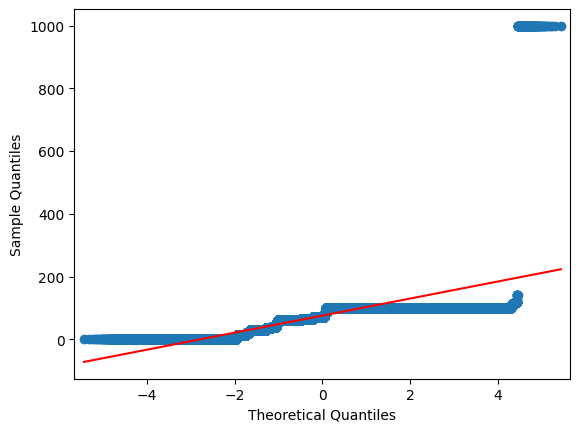

In [ ]:
# Q-Q Plot
sm.qqplot(presta_df['PRS_REM_TAU'], line='s')
plt.show()

Ce Q-Q plot illustre clairement la concentration des valeurs extrêmes autour de 1000 %, ce qui peut indiquer des cas spécifiques de prestations. Ces anomalies pourraient être liées à des prestations exceptionnelles, où des remboursements très élevés sont justifiés, ou bien à des erreurs de saisie ayant un impact notable sur la distribution des données.
Ces observations soulignent l'importance d'analyser en profondeur ces points atypiques pour en déterminer la cause. Une vérification ciblée des prestations correspondantes dans la base de données permettrait de distinguer les cas légitimes des erreurs. Cela pourrait également éclairer des ajustements potentiels dans les calculs ou la présentation des données.

In [ ]:
# Prestation avec un taux de remboursement supérieur à 900%
sup900_rem_taux = presta_df[presta_df['PRS_REM_TAU'] > 900]
sup900_rem_taux.head()

,AGE_BEN_SNDS,BEN_SEX_COD,PRS_ACT_QTE,PRS_PAI_MNT,PRS_REM_MNT,PRS_REM_BSE,PRS_REM_TAU,PRS_NAT,PRS_NAT_DESC,DIFF
342460,0,2,1,1.29,1.10,0.0,999.0,3384,HONO DISP 2,0.19
475851,0,2,1,2.38,2.02,0.0,999.0,3341,PHARMACIE 15%,0.36
549020,60,2,1,8.52,2.98,0.0,999.0,3313,PHARMACIE 65%,5.54
733194,40,2,1,1917.84,323.57,0.0,999.0,2111,FRAIS D HEBERGEMENT ET ENVIRONNEMENT EN GHS,1594.27
776561,0,2,1,1.47,0.51,0.0,999.0,3313,PHARMACIE 65%,0.96


In [87]:
sup900_rem_taux.shape[0]

157

L'analyse des dimensions de la table contenant les prestations avec un taux de remboursement supérieur à 900 % révèle qu'elles ne regroupent que **157 observations**. Ces cas, bien qu'inhabituels, semblent spécifiques à certaines prestations ou contextes exceptionnels. Cela pourrait correspondre à des remboursements hors normes, à des situations régies par des règles particulières, ou encore à des anomalies administratives. Ces prestations rares mériteraient une étude approfondie pour mieux comprendre leur origine et leur éventuel impact sur les données globales.

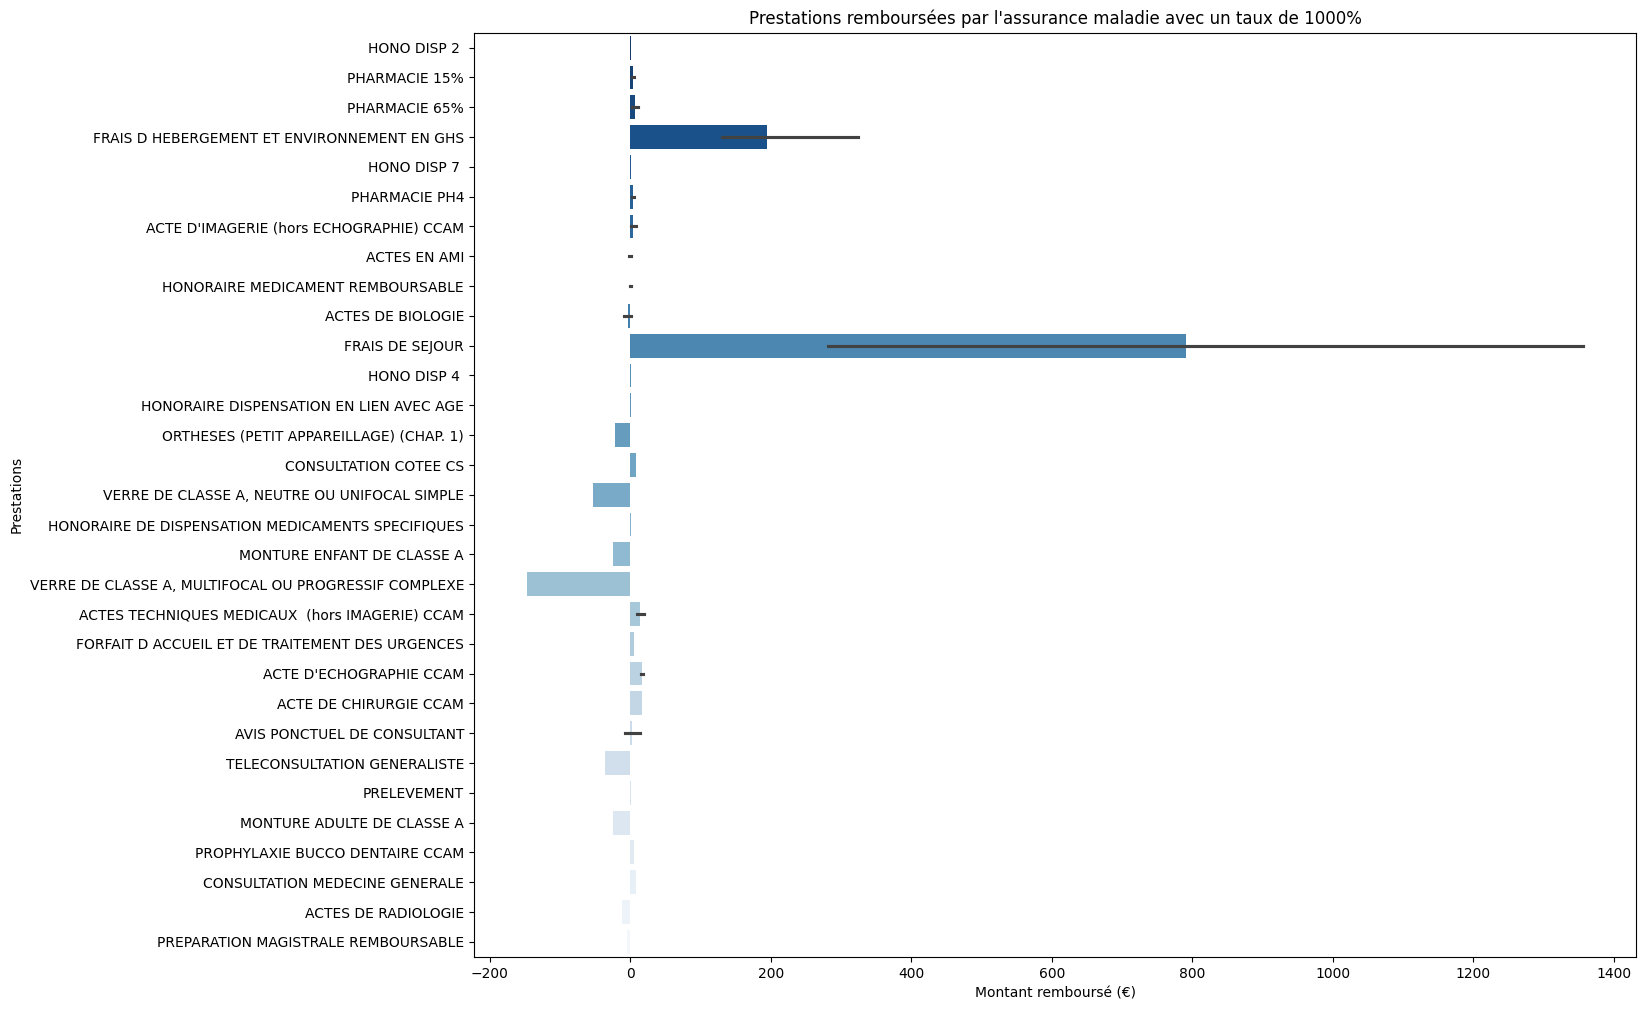

In [ ]:
plt.figure(figsize=(15, 12))
sns.barplot(
    x='PRS_REM_MNT',
    y='PRS_NAT_DESC',
    data=sup900_rem_taux,
    palette='Blues_r',
    hue='PRS_NAT_DESC',
    dodge=False,
    legend=False
)

plt.xlabel('Montant remboursé (€)')
plt.ylabel('Prestations')
plt.title("Prestations remboursées par l'assurance maladie avec un taux de 1000%")
plt.show()

Ce graphique met en lumière les prestations associées à des taux de remboursement inhabituels observés en amont, généralement bien supérieurs aux standards observés. Ce qui intrigue, c'est que ces prestations correspondent habituellement à des remboursements effectués à des taux standards par l'assurance maladie. Cela suggère fortement que ces anomalies pourraient être dues à des erreurs de saisie dans la base de données, plutôt qu'à des situations légitimes ou spécifiques. Une vérification approfondie de ces cas pourrait être nécessaire pour confirmer cette hypothèse et garantir la qualité des données analysées.

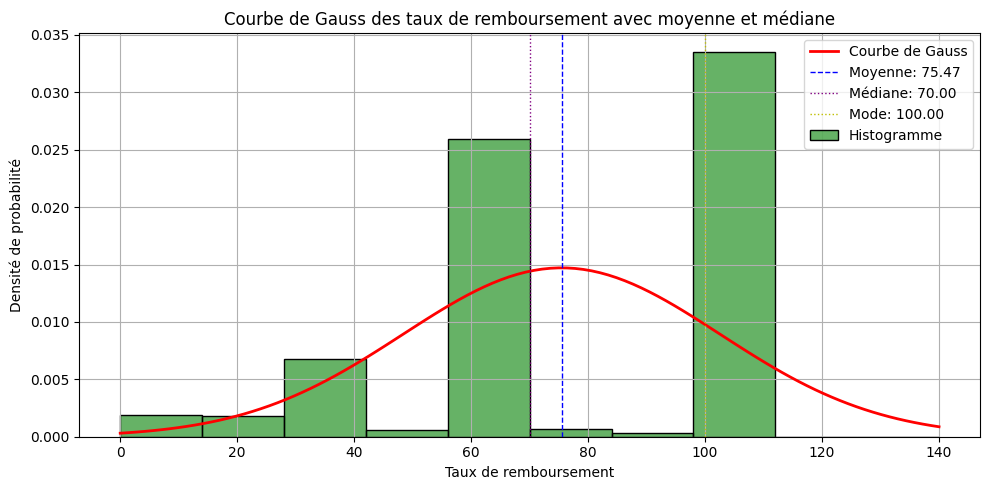

In [95]:
inf900_rem_taux = presta_df[presta_df['PRS_REM_TAU'] < 900]

mu, sigma = inf900_rem_taux['PRS_REM_TAU'].mean(), inf900_rem_taux['PRS_REM_TAU'].std()
median = inf900_rem_taux['PRS_REM_TAU'].median()
mode = inf900_rem_taux['PRS_REM_TAU'].mode().iloc[0]

# Tracé de l'histogramme avec Seaborn
plt.figure(figsize=(10, 5))
sns.histplot(
    inf900_rem_taux['PRS_REM_TAU'], bins=10, stat="density", kde=False, color='g', alpha=0.6, label='Histogramme'
)

# Calcul de la courbe de Gauss
bins = np.linspace(inf900_rem_taux['PRS_REM_TAU'].min(), inf900_rem_taux['PRS_REM_TAU'].max(), 100)
gauss_curve = norm.pdf(bins, mu, sigma)

# Tracé de la courbe de Gauss
plt.plot(bins, gauss_curve, linewidth=2, color='r', label='Courbe de Gauss')

# Ajout des lignes pour la moyenne et la médiane
plt.axvline(mu, color='b', linestyle='dashed', linewidth=1, label=f'Moyenne: {mu:.2f}')
plt.axvline(median, color='#800080', linestyle='dotted', linewidth=1, label=f'Médiane: {median:.2f}')
plt.axvline(mode, color='y', linestyle='dotted', linewidth=1, label=f'Mode: {mode:.2f}')

# Ajouter les éléments du graphique
plt.title("Courbe de Gauss des taux de remboursement avec moyenne et médiane")
plt.xlabel("Taux de remboursement")
plt.ylabel("Densité de probabilité")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

En écartant les valeurs extrêmes, il devient clair que les taux de remboursement se concentrent principalement dans une plage comprise entre 0 % et 140 %, avec une forte concentration autour de 100 %. Ce pic à 100 % reflète probablement les prestations les plus courantes ou les politiques standards de remboursement de l'assurance maladie. 

Cela est également cohérent avec l'observation précédente où les montants remboursés par l'assurance maladie apparaissent légèrement inférieurs ou, dans certains cas, équivalents aux montants dépensés par les patients, correspondant à une prise en charge complète. Cette concordance souligne la prévalence des remboursements proches des trois quarts du montant engagé, tout en laissant entrevoir des variations normales en fonction des prestations spécifiques ou des situations individuelles. (cf graphique **Montant remboursé, dépensé et nombre d'actes par age**)

In [ ]:
# PLOT agg_data_merged
plt.figure(figsize=(10, 5))
plt.plot(df['BEN_SEX_COD'] == 1, df['PRS_REM_MNT'], color='red', marker='o', label='Montant remboursé')
plt.plot(df['BEN_SEX_COD'] == 2, df['PRS_PAI_MNT'], color='blue', marker='o', label='Montant dépensé')
plt.plot(df['BEN_SEX_COD'] == 0, df['PRS_ACT_QTE'], color='green', marker='o', label='Quantité')
plt.xlabel('')
plt.ylabel(None)
plt.title('Montant remboursé par sexe')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\saeru\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


: 

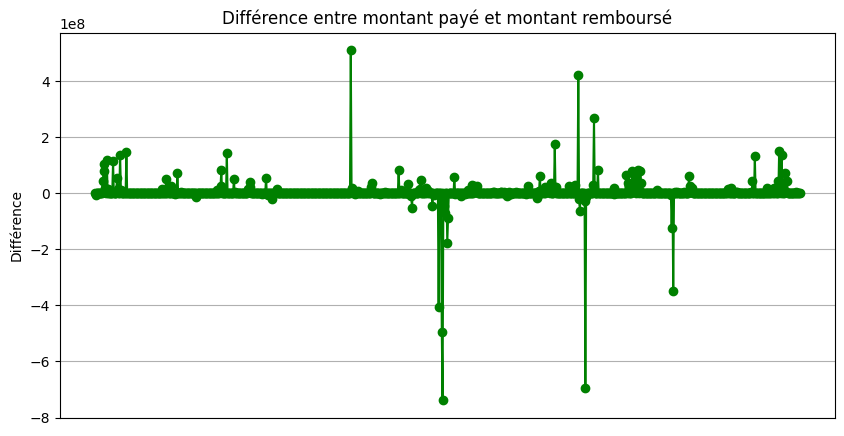

In [ ]:
# plot DIFF
diff_data = df.groupby('PRS_NAT_DESC')['DIFF'].sum().reset_index()
plt.figure(figsize=(10, 5))
plt.plot(diff_data['PRS_NAT_DESC'], diff_data['DIFF'], color='green', marker='o')

plt.xticks([])
plt.xlabel(None)
plt.ylabel('Différence')
plt.title('Différence entre montant payé et montant remboursé')
plt.grid(True)
plt.show()

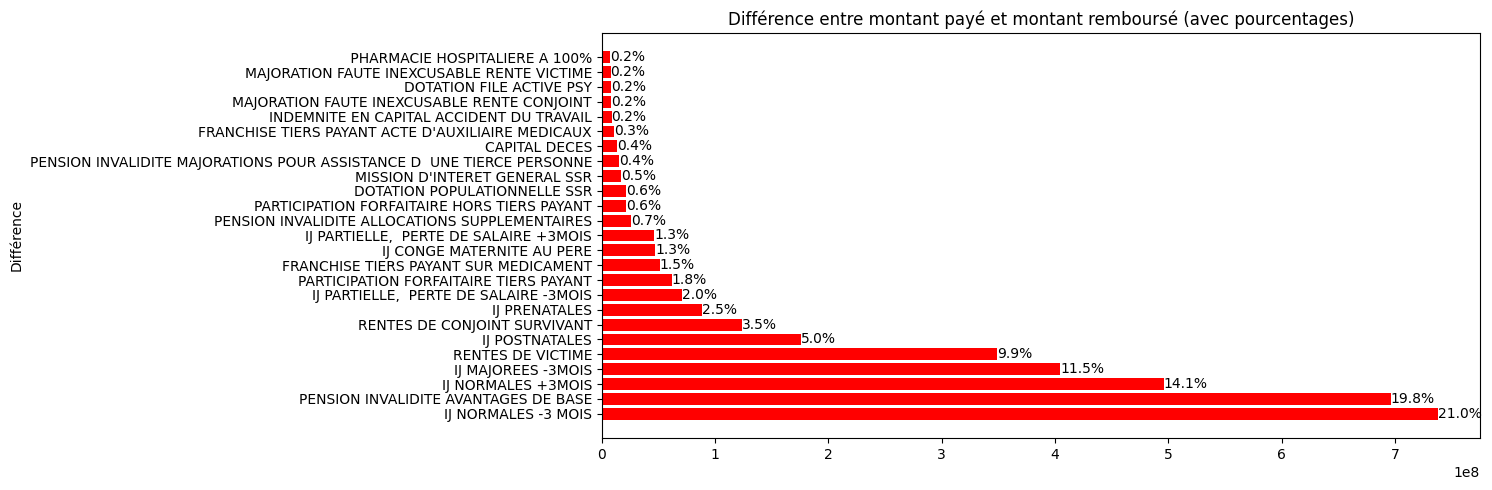

In [ ]:
# Filtrer les données avec des différences négatives, les trier et calculer les pourcentages
negative_diff_data = diff_data[diff_data['DIFF'] < 0].sort_values(by='DIFF', ascending=True).head(25).reset_index(drop=True)
negative_diff_data['DIFF'] = negative_diff_data['DIFF'].abs()
negative_diff_data['Percentage'] = (negative_diff_data['DIFF'] / negative_diff_data['DIFF'].sum()) * 100

# Créer le graphique en barres horizontales
plt.figure(figsize=(15, 5))
plt.barh(negative_diff_data['PRS_NAT_DESC'], negative_diff_data['DIFF'], color='red')

# Ajouter les pourcentages sur les barres
for index, value in enumerate(negative_diff_data['DIFF']):
    percentage = f"{negative_diff_data['Percentage'].iloc[index]:.1f}%"
    plt.text(value, index, percentage, va='center', ha='left')  # Ajouter le texte à la droite de chaque barre

# Supprimer l'étiquette de l'axe X
plt.xlabel(None)

# Ajouter un titre et une étiquette pour l'axe Y
plt.ylabel('Différence')
plt.title('Différence entre montant payé et montant remboursé (avec pourcentages)')

# Afficher le graphique
plt.tight_layout()
plt.show()


In [ ]:
age50_60 = df[(df['AGE_BEN_SNDS'] == 50) | (df['AGE_BEN_SNDS'] == 60)]

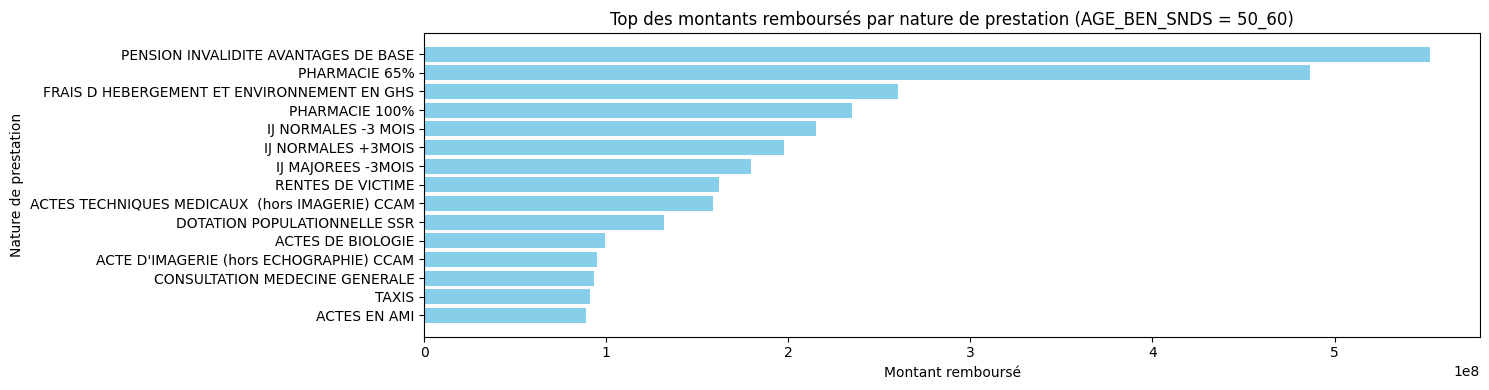

In [ ]:
# Regrouper les données par 'Description' et calculer la somme des valeurs
grouped_age_rem = age50_60.groupby('PRS_NAT_DESC')['PRS_REM_MNT'].sum().reset_index()

# Trier les données par 'FLT_REM_MNT' dans l'ordre décroissant
top_age_rem = grouped_age_rem.sort_values(by='PRS_REM_MNT', ascending=False).head(15)

# Tracer un diagramme en barres horizontal pour les 50 plus hautes prestations
plt.figure(figsize=(15, 4))  # Augmenter la hauteur pour une meilleure lisibilité
plt.barh(top_age_rem['PRS_NAT_DESC'], top_age_rem['PRS_REM_MNT'], color='skyblue')

# Ajouter des labels et un titre
plt.xlabel('Montant remboursé')
plt.ylabel('Nature de prestation')
plt.title('Top des montants remboursés par nature de prestation (AGE_BEN_SNDS = 50_60)')

# Inverser l'ordre pour afficher les barres du plus grand au plus petit
plt.gca().invert_yaxis()

# Afficher le graphique
plt.tight_layout()  # Pour ajuster les marges automatiquement
plt.show()

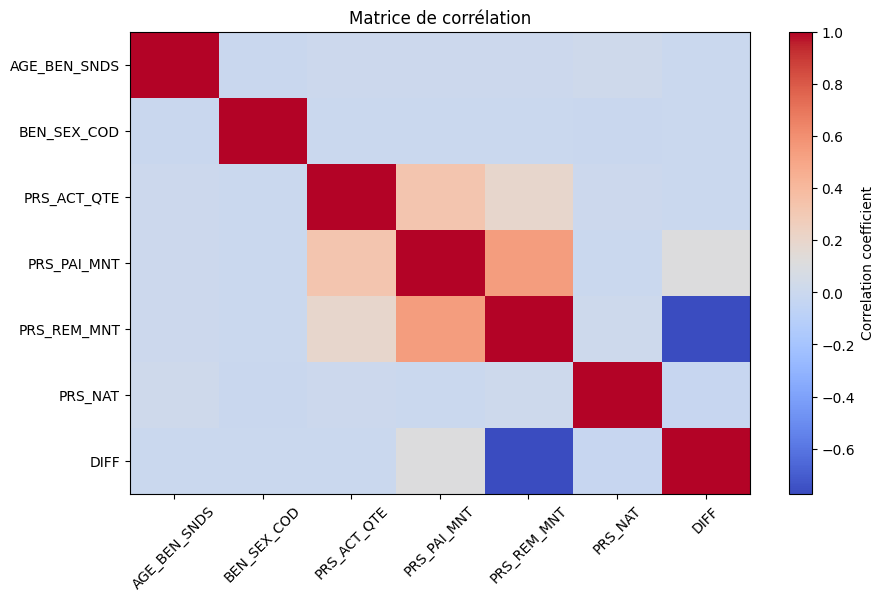

In [ ]:
# Matrice de corrélation (exclure les colonnes non numériques)
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Tracer la matrice de corrélation
plt.figure(figsize=(10, 6))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Correlation coefficient')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Matrice de corrélation')
plt.show()

In [ ]:
reg_data = pd.get_dummies(df, columns=['BEN_SEX_COD'], drop_first=True)

# Ensure all columns used in regression are numeric
X = reg_data[['AGE_BEN_SNDS', 'PRS_ACT_QTE', 'PRS_PAI_MNT', 'BEN_SEX_COD_2']].apply(pd.to_numeric)
y = reg_data['PRS_REM_MNT'].apply(pd.to_numeric)

# Convert boolean columns to integers
X['BEN_SEX_COD_2'] = X['BEN_SEX_COD_2'].astype(int)

# Ajouter une constante pour l'interception (ordonnée à l'origine)
X = sm.add_constant(X)

# Ajuster le modèle de régression linéaire
model = sm.OLS(y, X).fit()

# Résumé des résultats
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            PRS_REM_MNT   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 3.692e+06
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        01:06:53   Log-Likelihood:            -4.0357e+08
No. Observations:            36197289   AIC:                         8.071e+08
Df Residuals:                36197284   BIC:                         8.071e+08
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.5864      6.636      0.239

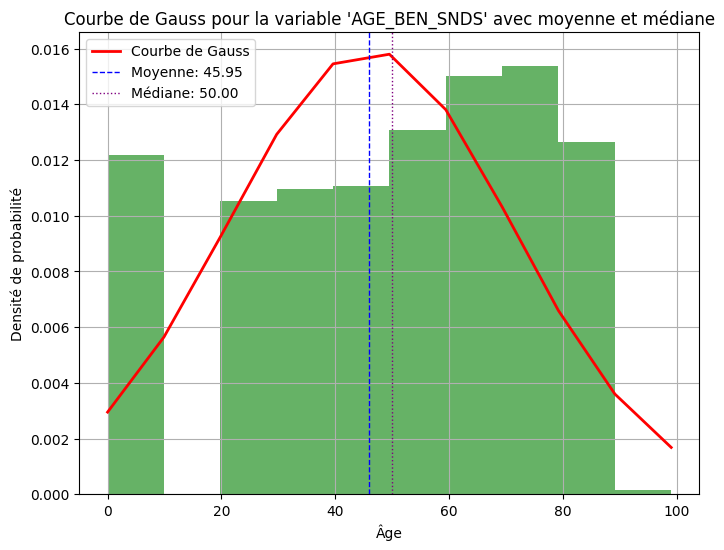

In [ ]:
# Calcul des paramètres de la distribution normale (moyenne et écart-type)
mu, sigma = df['AGE_BEN_SNDS'].mean(), df['AGE_BEN_SNDS'].std()
median = df['AGE_BEN_SNDS'].median()

# Tracé de l'histogramme des âges
plt.figure(figsize=(8, 6))
count, bins, ignored = plt.hist(df['AGE_BEN_SNDS'], bins=10, density=True, alpha=0.6, color='g')

# Calcul de la courbe de Gauss
gauss_curve = norm.pdf(bins, mu, sigma)

# Tracé de la courbe de Gauss
plt.plot(bins, gauss_curve, linewidth=2, color='r', label='Courbe de Gauss')
# Ajout des lignes pour la moyenne et la médiane
plt.axvline(mu, color='b', linestyle='dashed', linewidth=1, label=f'Moyenne: {mu:.2f}')
plt.axvline(median, color='#800080', linestyle='dotted', linewidth=1, label=f'Médiane: {median:.2f}')
plt.title("Courbe de Gauss pour la variable 'AGE_BEN_SNDS' avec moyenne et médiane")
plt.xlabel("Âge")
plt.ylabel("Densité de probabilité")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calcul des statistiques descriptives

statistiques_descriptives = {
'moyenne': df['AGE_BEN_SNDS'].mean(),
'médiane': df['AGE_BEN_SNDS'].median(),
'mode': df['AGE_BEN_SNDS'].mode().values[0],
'écart_type': df['AGE_BEN_SNDS'].std(),
'minimum': df['AGE_BEN_SNDS'].min(),
'maximum': df['AGE_BEN_SNDS'].max(),
'quantiles': df['AGE_BEN_SNDS'].quantile([0.25, 0.5, 0.75]).to_dict(),
'variance': df['AGE_BEN_SNDS'].var(),
'skewness': df['AGE_BEN_SNDS'].skew(),
'kurtosis': df['AGE_BEN_SNDS'].kurtosis()
}
# Affichage des statistiques descriptives
for stat, valeur in statistiques_descriptives.items(): 
    print(f'{stat}: {valeur}')

moyenne: 45.94771357048314
médiane: 50.0
mode: 70
écart_type: 25.001137652877905
minimum: 0
maximum: 99
quantiles: {0.25: 30.0, 0.5: 50.0, 0.75: 70.0}
variance: 625.0568839381493
skewness: -0.40108237390696294
kurtosis: -0.879663336825351
